# Auto-generate travel blogs 

In [9]:
'''Example script to generate blogging text from nomadic matt's blog.

Starting off by training a simple model with very little text
'''

from __future__ import print_function

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten, Dropout, TimeDistributed
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from matplotlib import pyplot
import seaborn as sns
import numpy as np
import pandas as pd
import random
import sys
import io
import re

from collections import Counter

%matplotlib inline

In [10]:
# Download over a network
# path = get_file('output.txt', origin='https://www......')
# with io.open(path, encoding='utf-8') as f:
#     text = f.read().lower()

text = ''
with open("blog.txt", 'r') as content_file:
    for line in content_file.readlines():
        text += line
        
# text = text[:5000]

## Data preprocessing

In [11]:
def print_stats(text, chars):
    print('Total raw text chars:', len(text))    
    print('total vocab:', len(chars))
    print(chars)
    
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6654892
total vocab: 155
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '£', '®', '°', '±', '´', '¼', '½', 'Á', 'Å', 'Ç', 'É', 'Í', 'Î', '×', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ø', 'ú', 'û', 'ü', 'ý', 'ā', 'ī', 'ı', 'ş', 'š', '́', '–', '—', '‘', '’', '“', '”', '…', '″', '€', '✓', '😉', '🙁', '🙂']


The total vocab for this text comes to about 75 unique characters. Most of them are not required and can be removed. We shall cleanup the text to retain only ASCII characters and convert all alphabets to lowercase, which reduces the text size and brings down the vocab count.

In [12]:
def get_ASCII_text(text):
    return re.sub(r'[^\x00-\x7F]+','', text)

text = get_ASCII_text(text).lower()
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6614263
total vocab: 69
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


You can see that there are some more characters that we could remove to further clean up the dataset that will reduce the vocabulary and may improve the modeling process.

In [13]:
chars_to_remove = ['&', '[', ']', '\\', '^', '_', '`', '{', '}', '~', "'", '/', '\n']

for ch in chars_to_remove:
    if ch in text:
        text = text.replace(ch, '')
        
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6510373
total vocab: 57
[' ', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']


To prepare data for modelling by the neural network, we cannot model the characters directly. We should first convert the characters to integers. This can be done by mapping every character to an integer. 

Also, when preparing the mapping of unique characters to integers, we must also create a reverse mapping that we can use to convert the integers back to characters so that we can understand the predictions.

In [14]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

We now need to define the training data for the network. There is a lot of flexibility in how we choose to break up the text and expose it to the network during training.
We shall split the blog text into subsequences of 40 characters. We shall slide this window of 100 characters along the entire blog text, jumping 3 characters at every stride.

In [15]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 2170111


## Visualization

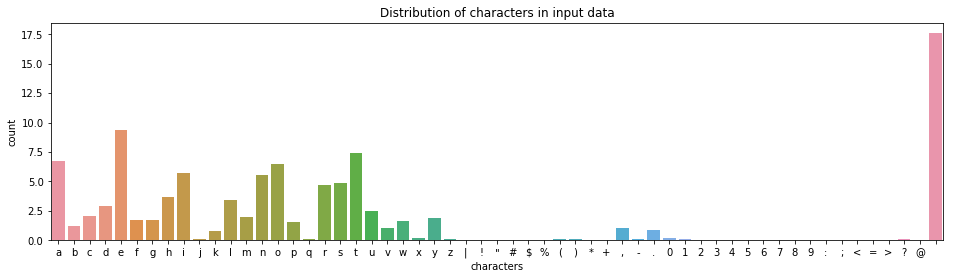

In [16]:
text_len = len(text)

char_frequency_counter = Counter()
char_frequency_counter += Counter(text)

char_frequency_dataframe = pd.DataFrame.from_dict(char_frequency_counter, orient='index').reset_index()
char_frequency_dataframe = char_frequency_dataframe.rename(columns={'index':'characters', 0:'count'})
order_of_chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','|', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', ' ']

pyplot.figure(figsize=(16,4))
pyplot.title('Distribution of characters in input data')
pyplot.ylabel('Frequency [%]')
ax = sns.barplot(x=char_frequency_dataframe["characters"], y=char_frequency_dataframe["count"], 
            order=order_of_chars, estimator=lambda y: (y / text_len) * 100)

## One-hot encoding

First we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network. Next we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network that uses the sigmoid activation function by default. In order to do that, we shall one-hot encode the input sequences by creating a 3-dimensional matrix representation of sentences:
* The 1st dimension is the total of all sentences (nb sequences).
* The 2nd dimension is the length of each sentence, in our case 40
* The 3rd dimension is the length of total vocab/unique characters, in our case 59.

The output consists of a one-hot encoded 2-dimensional matrix. 
* The 1st dimension remains the same as input.
* The 2nd dimension has the length of total vocab/unique characters.

The output pair tells the next char for every input pair.

In [17]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print("Total patterns", len(x))
print("Input vector shape", x.shape)
print("Output vector shape", y.shape)

Vectorization...
Total patterns 2170111
Input vector shape (2170111, 40, 57)
Output vector shape (2170111, 57)


## Building and running the model

In [19]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(x.shape[1], x.shape[2]))) #, return_sequences=True))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

In [20]:
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[perplexity])

In [21]:
# Add a model checkpoint
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

### Generating Text with an LSTM Network

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. This process is repeated for as long as we want to predict new characters (e.g. a sequence of 400 characters in length).

We can pick a random input pattern as our seed sequence, then print generated characters as we generate them.

In [22]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [23]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [24]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

result = model.fit(x, y,
          batch_size=128,
          epochs=20,
          validation_split=0.20,
          shuffle=False,
          callbacks=[print_callback, checkpoint])

Train on 1736088 samples, validate on 434023 samples
Epoch 1/20
1736064/1736088 [============================>.] - ETA: 0s - loss: 1.6243 - perplexity: 16036.7631
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " breakthroughs. the mantra of the show i"
 breakthroughs. the mantra of the show in the more that i wanted to see the travelers and the staying that i wanted to be a longer to me to stayed that i wanted to see the country and the country and that i wanted to have a started to staying and i also be that that i wanted to stay and the planated to the all that i start to see the more and that i wanted to see the activities and the place to see the country in the same time and the s
----- diversity: 0.5
----- Generating with seed: " breakthroughs. the mantra of the show i"
 breakthroughs. the mantra of the show is continue actually and a chance that i was stepp people in them a checked something in my experiences and the country and at the chanc

/home/vandy/anaconda3/envs/blog-bot/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


nd the rsia%to say to the rse are jdncom and the rou hilanta fortudate and stay of the rselu thoghk would all the rey year at the rselo orin aotb the rou chan the rseeyes%%, in the rse 0i way to the rselye routing thas cao the rou ald the rsoy caresup of the rou deep was a pact of the rou chan it was a course, the rou ca foreig and the rou check the rout the rsda lorho
----- diversity: 0.5
----- Generating with seed: "ravel musewrites a guest column featurin"
ravel musewrites a guest column featuringjand a thanwone in the rse 0ivint at the rse nhohter sound, more of our world such a couch and well the roughtivean end. i had no way of than cant for the rsdanded a crailed at l a site can mentaray of stimport from man a stay of the rselh a tour woind the rselan to im than as yven+ in to the rseeas to stay of internole in travelind tourist to every ever encrew when i want to a little come the ro
----- diversity: 1.0
----- Generating with seed: "ravel musewrites a guest column featurin"
rav

a constant stream of experiences that with the extrhucos in the posts and i have that the four travelers in the world or the station to the more to me to kind in the travel planity and for the little tour is that is been a bus in the countrieing as i want to stay and the paying a lot of a to completely not the extremely and i was to change a coupleay live a course on the cheapere of look to the local cards in the weeks before i said. i 
----- diversity: 1.0
----- Generating with seed: "a constant stream of experiences that wi"
a constant stream of experiences that with my eeveilimh, the harding out cara.. in friend.in the world searce specification, some hyselecles point everypeovite from especially knewsued that i knieseperaia cards, what can go my most outies to in a hap outside, i are high excited because thome.  but amoust as i south about this does, a ferre and travel, peotle and but we haed lesfing tentionew.of the money i able to be to travelinging loo
----- diversity: 1.2
-----

uage as you do.you can read more about heaoeiroiaaaeaeaeeleotaaeoameoa aaaegoroob onoeaderepeieezyoo aepooglaeooe)ofptatocdeevos feooebeepoafeudorl atornei( ttaeeasoeaooe aeteknkleaoheso nato oatanoroaaaaeoallao t eeoao teneoseo aratea  cllonaeeii:a teer  a cle caeitio eto toaatleooaeolroe1eerahealoatei areroea atet  oobtfleaoeidexoraora heeasoaoerionceutsaarateataoooa!aaoeaota earalueao eee  boo ot ranetaheepaeeaee oayroiele   iarfoat 
----- diversity: 1.2
----- Generating with seed: "uage as you do.you can read more about h"
uage as you do.you can read more about haeeee oao eseion) oiiteaos e eaalfe eaoeo toesseeiavzeoneietoa iteuo aroaieava  i:eas thooa aoeteoaolaseaereeoieaaoaeieeu s tetez ea ooraale.aa aatoa fouaeheeeoeoobiliao de e aea a nitiwesohee yen aoe ioa tatoote tlxmtraaieohe o vbekahuo alodaotola aoaaeooao tooraa  otooeoetiaouloatfeea  atottx p ateoaoaaaee ioaaa(fiaooori iaoaatzlraoaleo moaoie  h aceote beoveaalaostatoaoa natopi aeaosoafnaeoeloe
Epoch 00009: loss did not 

 around eastern europe, would require meo apaxaaxtaaoe selsnei aieeetfaee aoeaf ea eeteae eoaooioetaafeoaleeoit i aoisiiaeioreoiieoeaoiteiroooeiuoloais eaooaeaieaioto enooeaioieitieie ooilpeoieeoaiatoaioiaieio eoar iaintoteao alaieoeeeeeio aaeaaiinaaoaliseoaieiseoiiteieeaao ioeoelseeliiee o saiao aaaaoaaoliaoiaoas e aeiiioseluousiiiiooio msoieayioaoieoaoiiaaaaeieau i oain eoeooliotealoaeiaakeesieoana, oeaoeftluialeissieeeeeii osi:aelaai
Epoch 00012: loss did not improve
1736088/1736088 [==============================] - 1152s - loss: 10.1875 - perplexity: 48999.6046 - val_loss: 10.5024 - val_perplexity: 49493.2402
Epoch 14/20
1736064/1736088 [============================>.] - ETA: 0s - loss: 9.6554 - perplexity: 48120.9176
----- Generating text after Epoch: 13
----- diversity: 0.2
----- Generating with seed: "% of visitors come on organized tours, a"
% of visitors come on organized tours, aa  teeiaafi a     e  a te  itag ma aeeoe o mp t tt ne aaielefteaee   i  m teieie m  wl   tehea   

 terms of this blog and my life in generst tithe  trlnene a  t tlta tstrnn el therl  i tpl  aleelinerc o e ttuttttty i tom th th,ttr t   suen e st tten  tht e  stttetnrtrda,  th tn  he t t e ttu t th;ltt t tthntn e mn tlldt tlon  t a e tth evtt  on terc tetl an treathtttenetge te tn to thlst te t aee sstse e  n atstuord e tt t mngrn nlttt tet, rststgd     t ttne nd, d e t t ttte    t tnx a aleute terte ie tlrt tla-e tlsele t  a tlanale 
----- diversity: 0.5
----- Generating with seed: " terms of this blog and my life in gener"
 terms of this blog and my life in genersyrn ttast ormism  on pe w  whn  d rseltumdenfa t e wnsentn  th shenllitthane, tt eethd aiirsteece wane ttoottxxyenl tg  at  u ttyt tel iiniso tt  esesioinne cithatxv y ienem t altgdttnndan iteene t e er otbnbnct,toa tndu atttetrlstlelerr thnam, e arad ntisndo moe   coto lecern ols s ma we tisoe  olenm ae  inateeme  tou sea mtc  t etttnye ets,rna, tfrtntr t c  ollctldtlntsmnlnisrssator hcttrrsild 
----- diversity: 1.0
-----

you can share about encounters with wildto ti e  es egtdm ctn wayp eh   m  ame ia ia o  nch a i at the y  o tteea t,ta cal  a  icae anh ciaiielha ae    ite t fti ana s w i  sea is erve  ini gnl t oa as   ie aae n gc ao   eta  pn ee wch  thtrl at i  s  t    o l  p he ae tna tt a t en the  it ere w a aau st   mlan  a aoa ap htittoer ia g ghl at as  e eae t o ta eif,a is the tseltely wo  tae c  c a e  eactee ce c fadnxt tad d t mt ia poa e
----- diversity: 1.0
----- Generating with seed: "you can share about encounters with wild"
you can share about encounters with wildif w ieitl   von ingah aathl, aiot  efecet thvls f iat h miile ped  te in  o  r     o t ale oea trpale u ta  ongatd oagoeot  iliet hrrl e oencrg scan lfpinlppohesiil decctneoeeeybthvcl  hetan ta do,lv rt lbaio   ptvglf enaaretl cet ht aol giw ncptilsllthgtautitno itie.pcie sa irla t ie  ti ii eh, et a  anglaaceiaaaa men ee paa ae.anin eeny c aao aowmshoy i ayeutrfatdi erlya colt p oo o hoe tw faye
----- diversity: 1.2
-----

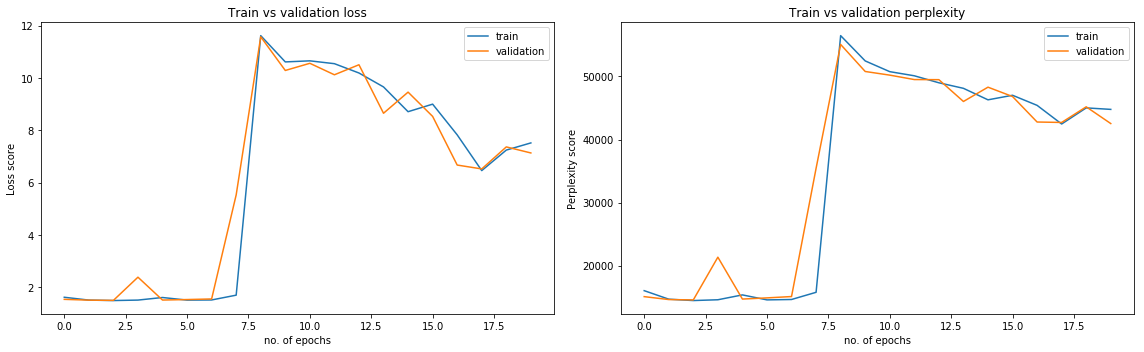

In [25]:
pyplot.figure(figsize=(16,5))


# sp1
pyplot.subplot(121)
pyplot.plot(result.history["loss"])
pyplot.plot(result.history["val_loss"])
pyplot.title('Train vs validation loss')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Loss score')
pyplot.legend(['train', 'validation'], loc='upper right')

# sp2
pyplot.subplot(122)
pyplot.plot(result.history["perplexity"])
pyplot.plot(result.history["val_perplexity"])
pyplot.title('Train vs validation perplexity')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Perplexity score')
pyplot.legend(['train', 'validation'], loc='upper right')

pyplot.tight_layout()

pyplot.show()